#### Importing Libraries & Loading the data ###

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\HP\OnlineRetail.csv", encoding='ISO-8859-1')

#### Initial Exploration ###

In [4]:
df.isnull().sum()/len(df)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [5]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
74031,542399,22639,SET OF 4 NAPKIN CHARMS HEARTS,5,1/27/2011 15:38,2.55,15549.0,United Kingdom
517190,580044,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,12/1/2011 12:36,3.75,14869.0,United Kingdom
39081,539631,20830,SILVER PHOTO FRAME,1,12/20/2010 15:03,4.21,NaN,United Kingdom
458541,575842,35970,ZINC FOLKART SLEIGH BELLS,8,11/11/2011 12:01,1.69,15024.0,United Kingdom
390749,570597,22770,MIRROR CORNICE,2,10/11/2011 11:49,14.95,16837.0,United Kingdom


### Data Cleaning / pre-processing ###

In [7]:
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)


In [8]:
desc_map = df.dropna(subset=['Description']).drop_duplicates('StockCode')[['StockCode', 'Description']].set_index('StockCode')['Description']

def fill_description(row):
    if pd.isna(row['Description']):
        if row['StockCode'] in desc_map:
            return desc_map[row['StockCode']]
        else:
            return "Unknown"
    else:
        return row['Description']
df['Description'] = df.apply(fill_description, axis=1)

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [10]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

### Feature Engineering ###

In [13]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Weekday'] = df['InvoiceDate'].dt.day_name()
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

### Customer Segmentation ###

In [15]:
snapshot_date = (df['InvoiceDate'].max() + pd.Timedelta(days=1)).normalize()
grouped = df.groupby('CustomerID')

def calc_recency(last_date):
    if pd.isna(last_date):
        return None
    else:
        return (snapshot_date - last_date).days
recency = grouped['InvoiceDate'].max().apply(calc_recency)

frequency = grouped['InvoiceNo'].nunique()

monetary = grouped['TotalPrice'].sum()

rfm = pd.DataFrame({
    'CustomerID': recency.index,
    'Recency': recency.values,
    'Frequency': frequency.values,
    'Monetary': monetary.values
})

In [16]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int) # Lower recency = better (recent buyers get higher score)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, duplicates='drop').cat.codes + 1
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int) # Higher monetary = higher score

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [17]:
def segment_customer(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['F_Score'] >= 3 and row['R_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 2:
        return 'Potential Loyalists'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'At Risk'
    elif row['R_Score'] >= 2 and row['F_Score'] <= 2:
        return 'Need Attention'
    else:
        return 'Lost'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
print(rfm[['CustomerID', 'RFM_Score', 'Segment']].head())


   CustomerID RFM_Score         Segment
0       12346       115            Lost
1       12347       545       Champions
2       12348       234         At Risk
3       12349       414  Need Attention
4       12350       112            Lost


### Visualization ###

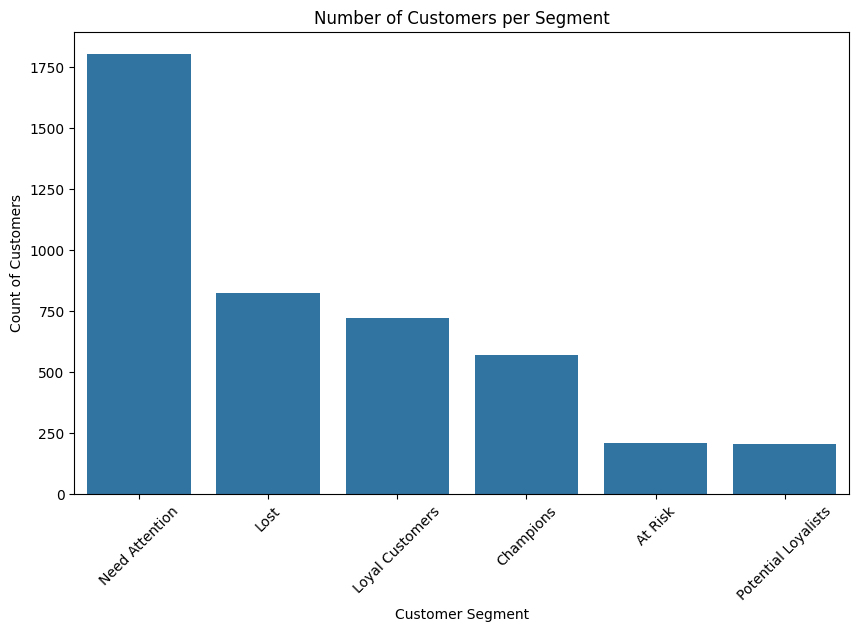

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Number of Customers per Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Count of Customers')
plt.xticks(rotation=45)
plt.show()

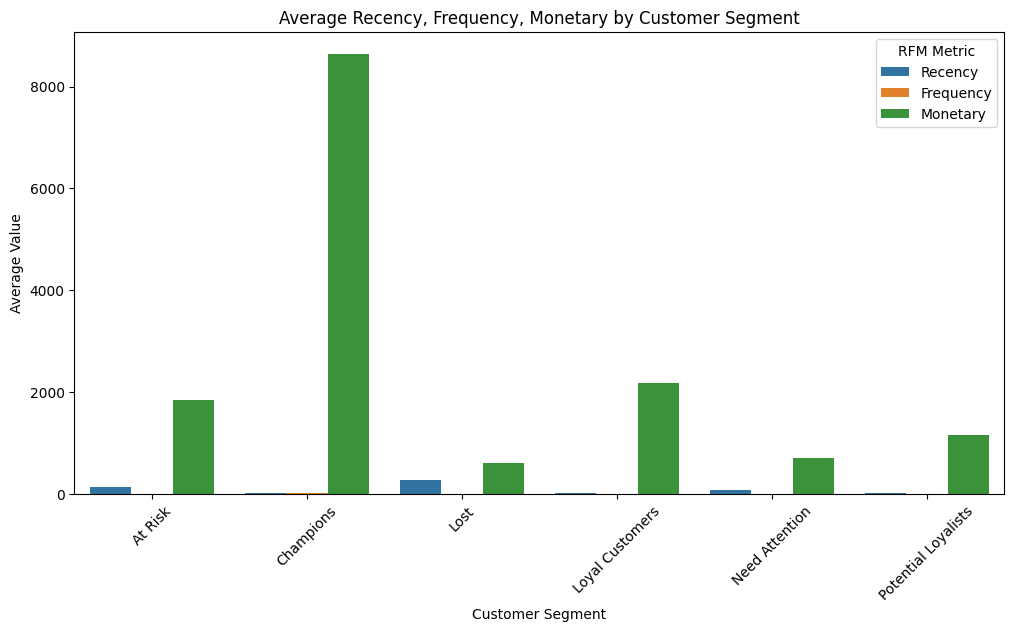

In [20]:
rfm_grouped = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=rfm_grouped.melt(id_vars='Segment'), x='Segment', y='value', hue='variable')
plt.title('Average Recency, Frequency, Monetary by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='RFM Metric')
plt.show()

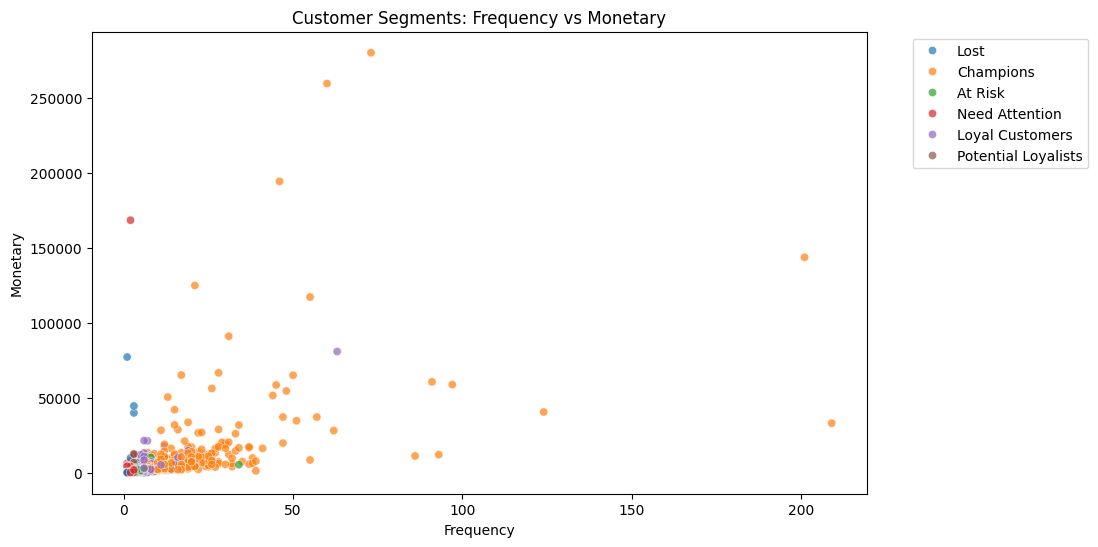

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', alpha=0.7)
plt.title('Customer Segments: Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()